<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pretrained-GAN" data-toc-modified-id="Pretrained-GAN-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pretrained GAN</a></span></li><li><span><a href="#Crappified-data" data-toc-modified-id="Crappified-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Crappified data</a></span></li><li><span><a href="#Pre-train-generator" data-toc-modified-id="Pre-train-generator-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Pre-train generator</a></span></li><li><span><a href="#Save-generated-images" data-toc-modified-id="Save-generated-images-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Save generated images</a></span></li><li><span><a href="#Train-critic" data-toc-modified-id="Train-critic-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train critic</a></span></li><li><span><a href="#GAN" data-toc-modified-id="GAN-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>GAN</a></span></li><li><span><a href="#fin" data-toc-modified-id="fin-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>fin</a></span></li></ul></div>

## Pretrained GAN

1:00:09 Image Restoration: https://www.youtube.com/watch?v=9shn3Oz7Ptw

In [2]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
##from fastai.vision.gan import *

In [3]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

## Crappified data

Prepare the input data by crappifying images.

In [4]:
from PIL import Image, ImageDraw, ImageFont

In [5]:
def crappify(fn,i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, 96, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    w,h = img.size
    q = random.randint(10,70)
    ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
    img.save(dest, quality=q)

Uncomment the first time you run this notebook.

In [6]:
##il = ImageItemList.from_folder(path_hr)
##parallel(crappify, il.items)

For gradual resizing we can change the commented line here.

In [7]:
bs,size=32, 128
# bs,size = 24,160
#bs,size = 8,256
arch = models.resnet34

## Pre-train generator

Now let's pretrain the generator.

In [8]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).random_split_by_pct(0.1, seed=42)

In [9]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [10]:
data_gen = get_data(bs,size)

In [57]:
?data_gen

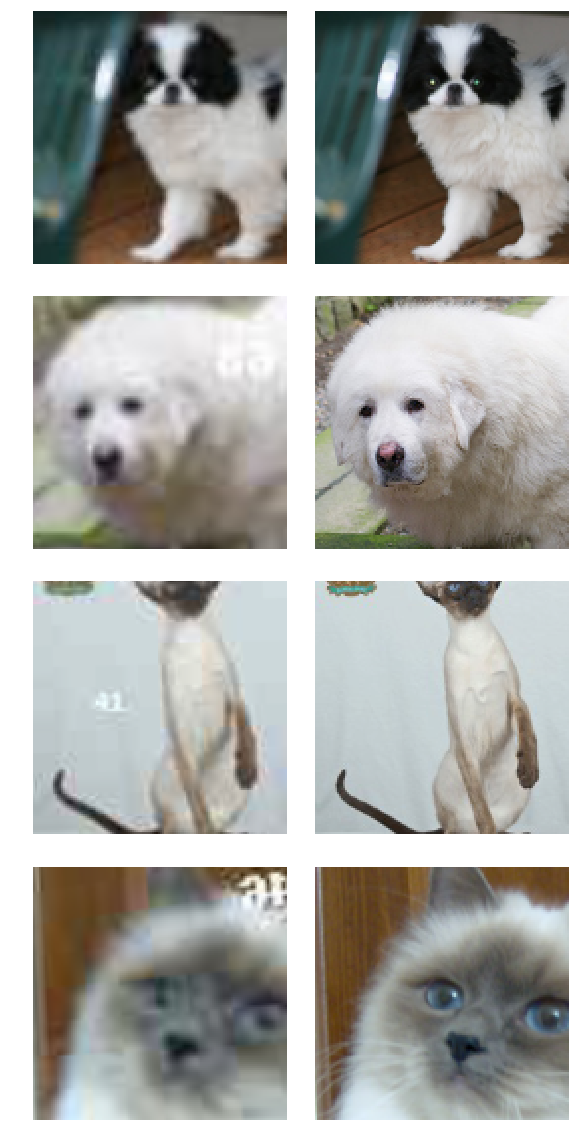

In [11]:
data_gen.show_batch(4)

In [16]:
wd = 1e-3

In [17]:
y_range = (-3.,3.)

In [18]:
loss_gen = MSELossFlat()

In [30]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, loss_func=loss_gen)
    ##   return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
     ##                        self_attention=True, y_range=y_range, loss_func=loss_gen)

In [31]:
learn_gen = create_gen_learner()

In [32]:
learn_gen.unfreeze()

In [33]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

epoch,train_loss,valid_loss
1,0.534479,0.465014
2,0.366708,0.337686
3,0.316144,0.301673


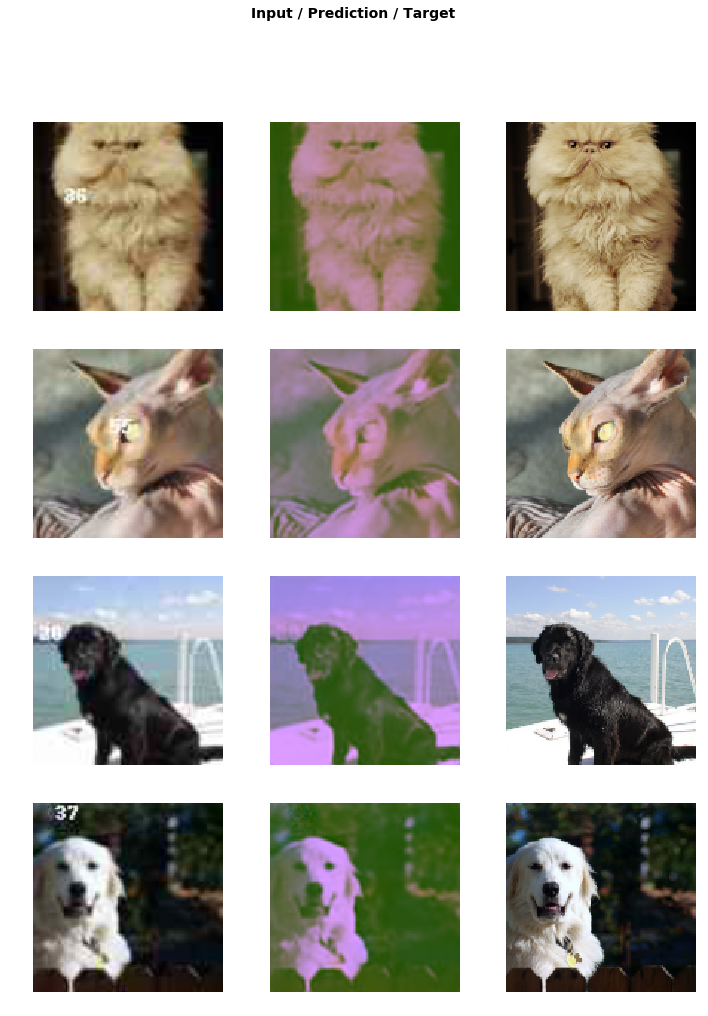

In [34]:
learn_gen.show_results(rows=4)

In [35]:
learn_gen.save('gen-pre2')

## Save generated images

In [36]:
learn_gen.load('gen-pre2');

In [37]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [ ]:
# shutil.rmtree(path_gen)

In [38]:
path_gen.mkdir(exist_ok=True)

In [50]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [58]:
save_preds(data_gen.fix_dl)
##save_preds(data_gen.train_dl)

AttributeError: 'ImageItemList' object has no attribute 'fix_dl'

In [47]:
PIL.Image.open(path_gen.ls()[0])

IndexError: list index out of range

- Problem: Mean squared error does not fully describe, what we want!

- 2:32:12: https://www.youtube.com/watch?v=9shn3Oz7Ptw

## Train critic

In [59]:
## release memory
learn_gen=None
gc.collect()

46079

Pretrain the critic on crappy vs not crappy.

In [60]:
def get_crit_data(classes, bs, size):
    src = ImageItemList.from_folder(path, include=classes).random_split_by_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [61]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

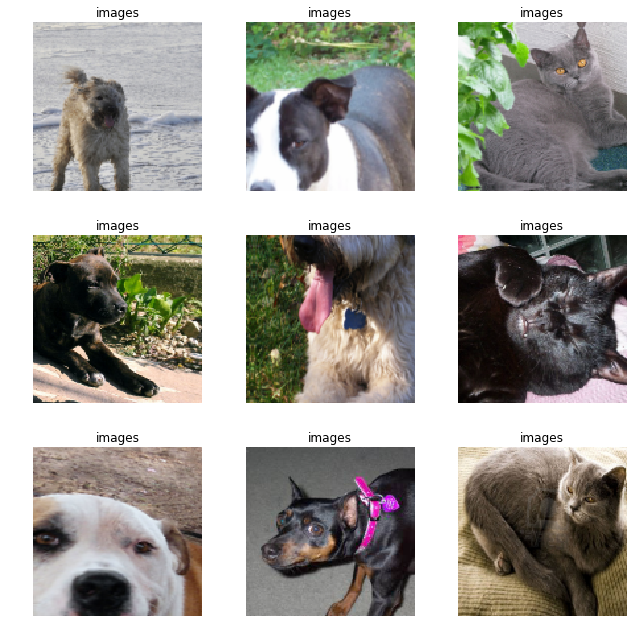

In [62]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [65]:
## Adaptive Loss will be explained later on
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

NameError: name 'AdaptiveLoss' is not defined

In [66]:
## no resnet (maybe pre-trained?), spectro normalisation 
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [ ]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [ ]:
learn_critic.fit_one_cycle(6, 1e-3)

In [ ]:
learn_critic.save('critic-pre2')

## GAN

1:11:30 https://www.youtube.com/watch?v=9shn3Oz7Ptw

Loss function, which calls another model

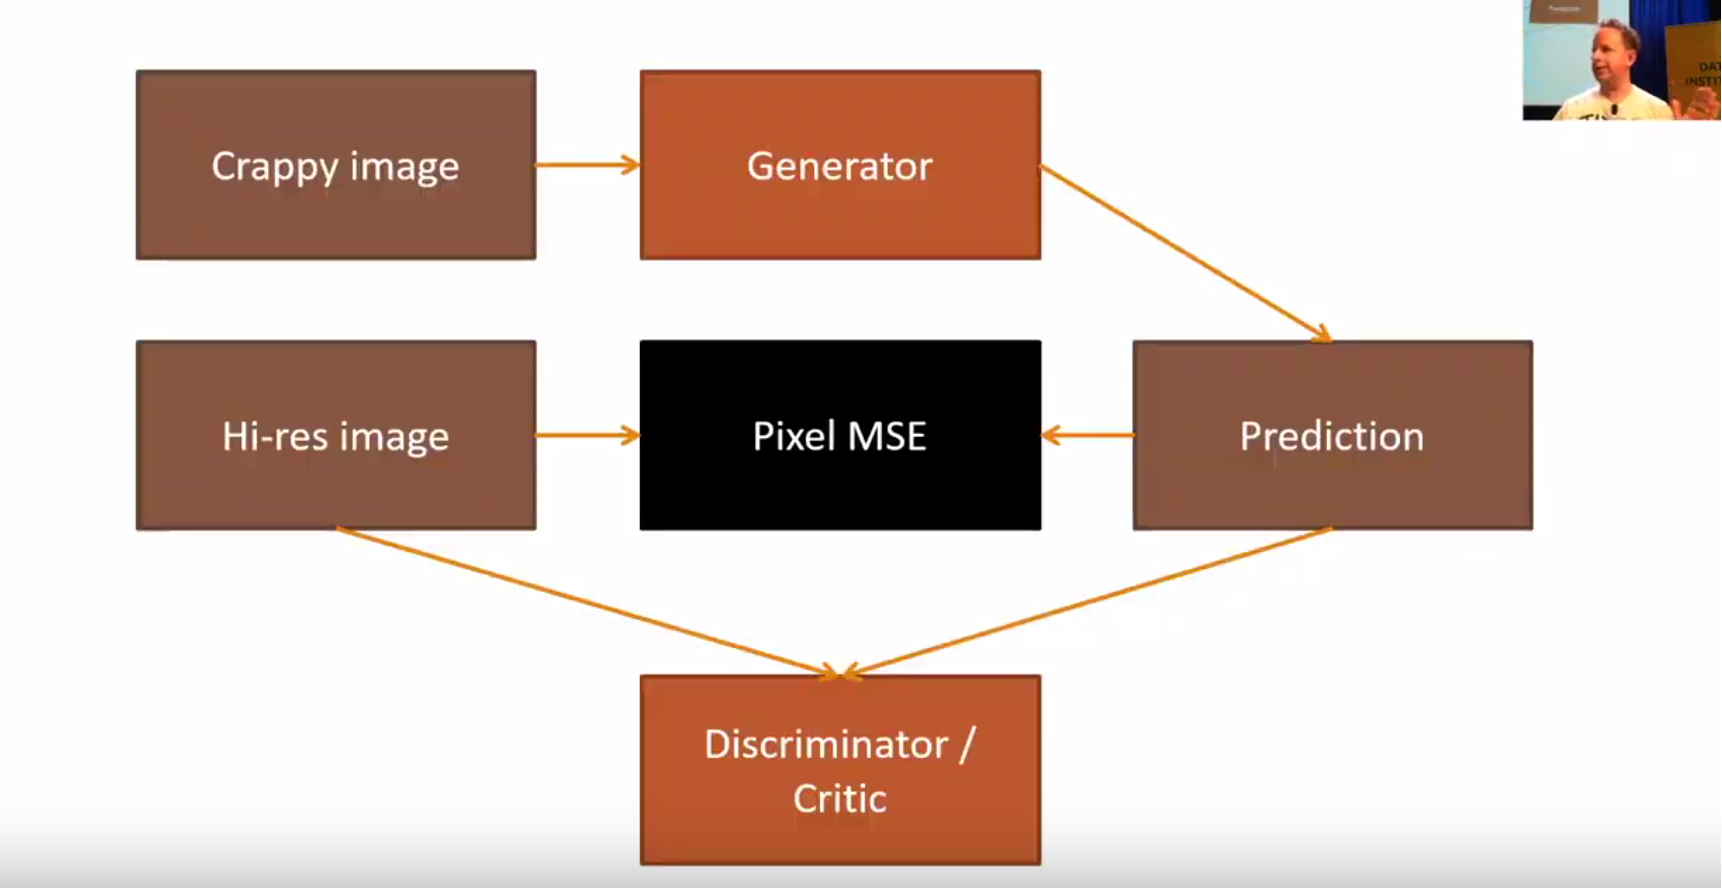

We have a crappy image, a generator, which creates predictions. So we compare that prediction image via a Loss function.

Now we try to build a binarcy classification that takes pairs of real and predicted images and classifies, which is which. That will be a regular, binary class entropy classifier.

Now we can fine train the initial generaltor and instead of using the standard loss function, we measure how good are we to fool the critic.

Now the critic needs constant retraining on the newly generated images, because they will get better and better.

Then, these train each other back and forth.

fast.ai also pre-trains the generator and the critic. This alleviates the pain of training GANs. If you do not pre-train you have the 'blind training the blind'.

Note we add together pixel loss and critic loss so the generator does not create pictures that have nothing to do with the original picture byt somehow manage to fool the judge.

Now we'll combine those pretrained model in a GAN.

In [ ]:
learn_crit=None
learn_gen=None
gc.collect()

In [ ]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)

In [ ]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')

In [ ]:
learn_gen = create_gen_learner().load('gen-pre2')

To define a GAN Learner, we just have to specify the learner objects foor the generator and the critic. The switcher is a callback that decides when to switch from discriminator to generator and vice versa. Here we do as many iterations of the discriminator as needed to get its loss back < 0.5 then one iteration of the generator.

The loss of the critic is given by `learn_crit.loss_func`. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predicitions (target 0). 

The loss of the generator is weighted sum (weights in `weights_gen`) of `learn_crit.loss_func` on the batch of fake (passed throught the critic to become predictions) with a target of 1, and the `learn_gen.loss_func` applied to the output (batch of fake) and the target (corresponding batch of superres images).

In [ ]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
## momentum 'kind of' does not make sense, since we switch between both
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [ ]:
lr = 1e-4

In [ ]:
## note the loss numbers here are kind of meaningless, you would expect them to go down but they do not
## the numbers should stay about the same as both oppnents get trained and better
## Therefore, it is hard with GANs to measure how good they are. Often, one simply has to look atthe pictures 
learn.fit(40,lr)

In [ ]:
learn.save('gan-1c')

In [ ]:
learn.data=get_data(16,192)

In [ ]:
learn.fit(10,lr/2)

In [ ]:
learn.show_results(rows=16)

In [ ]:
learn.save('gan-1c')

## fin